# Reduce Vocabulary

This notebook is about minimizing the size of our vocabulary.
We will use pretrained vectors (Tayga) as well as trained on our own (using gensim's word2vec and GloVe).

## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_rus = pd.read_excel("home_appliances_rus.xlsx", index_col=0)

In [3]:
df_tags = pd.read_excel("home_appliances_with_tags.xlsx", index_col=0)
print(f"Loaded {df_tags.shape[0]} rows")
df_tags.head(1)

Loaded 6802 rows


,title,text,source_type,source,date,home_appliances,MAIN_1: НЕРЕЛЕВАНТ,MAIN_1: Продаж нової техніки,MAIN_1: Продаж Б/У,MAIN_1: Ремонт/Поломки/Деталі,...,MAIN_2: Морозильна камера,MAIN_2: Духовка,MAIN_2: Варочні поверхні,MAIN_2: Витяжка,MAIN_2: Мікрохвильовка,MAIN_2: Кондиціонер,MAIN_2: Пилосос,MAIN_2: Бойлер,clean_text,lang
0,Инверторные кондиционеры | Купить в Москве по ...,<p>Инверторные кондиционеры | Купить в Москве ...,Социальные сети,facebook,2022-01-20 15:53:00,True,False,True,False,False,...,False,False,False,False,False,True,False,False,инверторные кондиционеры купить в москве по вы...,ru


In [4]:
df_tags.drop(columns=['title', 'text', 'source_type', 'source', 
                      'date', 'home_appliances', 'clean_text', 'lang'], inplace=True)

In [5]:
df_tags = df_tags.loc[df_rus.index, :]

In [6]:
df_tags.columns

Index(['MAIN_1: НЕРЕЛЕВАНТ', 'MAIN_1: Продаж нової техніки',
       'MAIN_1: Продаж Б/У', 'MAIN_1: Ремонт/Поломки/Деталі',
       'MAIN_1: Послуги', 'MAIN_1: Огляд', 'MAIN_1: Розіграші',
       'MAIN_1: Продажа(здача) квартир з подутовою технікою',
       'MAIN_1: Корп активність в компанії', 'MAIN_1: Софти',
       'MAIN_1: Відгуки в інтернет-магазинах (розширити тематику)',
       'MAIN_1: Вакансії/робота', 'MAIN_1: інші електронні пристрої',
       'MAIN_2: Холодильник', 'MAIN_2: Пральна машина', 'MAIN_2: Сушка',
       'MAIN_2: Посудомийка', 'MAIN_2: Морозильна камера', 'MAIN_2: Духовка',
       'MAIN_2: Варочні поверхні', 'MAIN_2: Витяжка', 'MAIN_2: Мікрохвильовка',
       'MAIN_2: Кондиціонер', 'MAIN_2: Пилосос', 'MAIN_2: Бойлер'],
      dtype='object')

In [7]:
all_tags = list(df_tags.columns)
tag2id = {tag:i for i, tag in enumerate(all_tags)}
id2tag = {i:tag for tag, i in tag2id.items()}

## Create vocabulary

In [8]:
lemmatized = {}
for index in df_rus.index:
    lemmatized[index] = df_rus.loc[index, "lemmatized_with_pos"].split(" ")

vocab = []
for tokens in lemmatized.values():
    for word in tokens:
        if word not in vocab:
            vocab.append(word)

print(f"Total length of vocabulary is -- {len(vocab)}")

Total length of vocabulary is -- 27549


Create word to index mapper

In [9]:
word2ind = {}
ind2word = {}
n = 0
for word in vocab:
    word2ind[word] = n
    ind2word[n] = word
    n += 1

lemmatized_w_ids = {}
for key, tokens in lemmatized.items():
    new_tokens = []
    for word in tokens:
        new_tokens.append(word2ind[word])
    lemmatized_w_ids[key] = new_tokens

## Load tayga model

In [10]:
import gensim
print('Loading the Tayga model...', end='\r', flush=True)
tayga_file = r"C:\Users\BHaiov01\Documents\MLmodels/tayga_model.bin"
tayga = gensim.models.KeyedVectors.load_word2vec_format(tayga_file, binary=True)
print('Loading the Tayga model... Done.')

Loading the Tayga model... Done.


In [13]:
# from lemmatization import process, process_pipeline

# get vector of processed word in tayga model
def get_vector(tagged_word, word2vec_model=None):
    if tagged_word in word2vec_model.key_to_index.keys():
        vec = word2vec_model.get_vector(word2vec_model.key_to_index[tagged_word])
#         print("yes")
        return vec
    else:
#         print("no")
        return None

Create a dict with vectors for words from the vocab

In [14]:
vectors = {}
n_empty_vectors = 0
for word_tagged in vocab:
    vector = get_vector(word_tagged, word2vec_model=tayga)
    
    if vector is None:
        n_empty_vectors += 1
    
    if word_tagged is not None:
        vectors[word_tagged] = vector
    else:
#         print(word)
        vectors[word_tagged] = vector


print(f"{n_empty_vectors} / {len(vocab)} vectors are empty")

13238 / 27549 vectors are empty


Поглянемо на к-сть іменників, прикметників та дієслів, що мають вектори

In [15]:
counts = {}
counts["ADJ"] = 0
counts["NOUN"] = 0
counts["VERB"] = 0
for word, vec in vectors.items():
    if vec is None:
        continue
        
    pos_tag = word.split("_")[-1]
    
    if pos_tag not in counts.keys():
        counts[pos_tag] = 0
    
    counts[pos_tag] += 1

print(counts)

{'ADJ': 2724, 'NOUN': 6122, 'VERB': 3177, 'X': 887, 'ADV': 887, 'NUM': 50, 'PRON': 24, 'ADP': 108, 'PROPN': 223, 'DET': 35, 'PART': 42, 'SCONJ': 13, 'CCONJ': 7, 'INTJ': 7, 'AUX': 5}


Поглянемо на к-сть іменників, прикметників та дієслів, що НЕ мають векторів

In [16]:
counts = {}
counts["ADJ"] = 0
counts["NOUN"] = 0
counts["VERB"] = 0
for word, vec in vectors.items():
    if word is None:
        continue
    
    pos_tag = word.split("_")[-1]
    
    if pos_tag not in counts.keys():
        counts[pos_tag] = 0
    
    if vec is None:    
        counts[pos_tag] += 1
        
print(counts)

{'ADJ': 1417, 'NOUN': 4363, 'VERB': 961, 'X': 5073, 'PROPN': 562, 'ADV': 398, 'NUM': 178, 'ADP': 141, 'PRON': 12, 'DET': 57, 'PART': 56, 'INTJ': 6, 'SCONJ': 7, 'CCONJ': 4, 'AUX': 3}


In [17]:
empty_vectors = {w: v for w, v in vectors.items() if (w is not None and v is None)}

Окей, ми маємо вектори лише для половини слів. Це хуйово, але не критично. Спробуємо зменшити к-сть слів хоча б на 25% від всього обсягу (тобто на 50% від тієї половини, що має вектори). Також, варто вилучити звідти всі слова, які є серед наших тегів (щоб холодильник та пралка не змішались до купи)

## Reduce vocab size

Напишемо ф-цію, яка перевірить чи це слово є в початковому запиті при зборі даних

In [18]:
from string import digits
from requests_finder import load_request
import re


def contains_mention(text):
    """
    Function checks if there is a mention of tags in the text
    """
    global req
    
    if re.findall(req.lower(), text.lower()) == []:
        return False
    else:
        return True

def decompose_initial_request(path_to_req):
    with open(path_to_req, "r", encoding="utf8") as f:
              req = f.readlines()[0]
    
    new_req_list = []
    req = req.replace("(", "")
    req = req.replace(")", "")
    req = req.replace("/", "")
    req = req.replace("AND", "")
    req = req.replace("OR", "")
    for digit in digits:
        req = req.replace(str(digit), "")
    
    for t in req.split():
        new_req_list.append(t)
        
    new_req = " OR ".join(new_req_list)
    
    return new_req

In [19]:
req = decompose_initial_request(path_to_req="request.txt")
req = load_request(request=req)

Виберемо тільки ті слова, що мають вектори, або підходять під початковий запит

In [20]:
lemmatized_with_vectors = {}
empty_words = list(empty_vectors.keys())

num_empty_texts = 0
for index, tokens in lemmatized.items():
    lemmatized_with_vectors[index] = [t for t in tokens if t not in empty_words or contains_mention(t)]
    
    if len(lemmatized_with_vectors[index]) == 0:
        num_empty_texts += 1
        
print(num_empty_texts)

0


Ми бачимо, що к-сть текстів, де всі слова не мали векторів рівна нулю, а отже, ми можемо спробувати викинути ці слова зі словника. Проте, спершу перевіримо який вплив це матиме на самі повідомлення

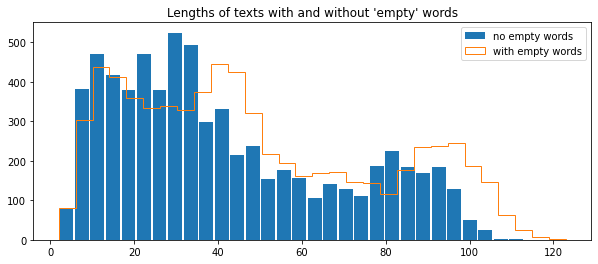

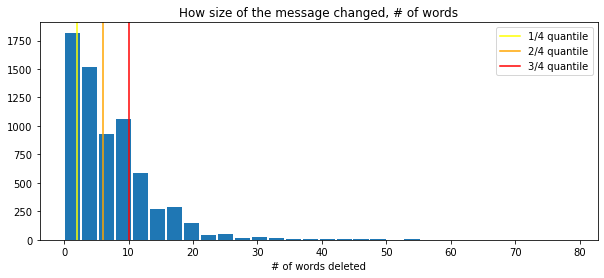

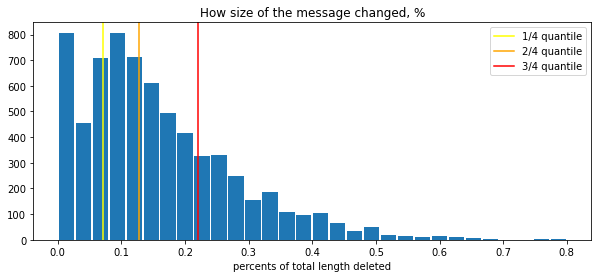

In [21]:
len_of_texts_no_empty_words = [len(v) for v in lemmatized_with_vectors.values()]
len_of_texts_with_empty_words = [len(v) for v in lemmatized.values()]

plt.figure(figsize=(10, 4))
plt.hist(len_of_texts_no_empty_words, bins=30, rwidth=0.9, label="no empty words")
plt.hist(len_of_texts_with_empty_words, bins=30, rwidth=0.9, label="with empty words", histtype="step")
plt.title("Lengths of texts with and without \'empty\' words")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
diff_between_two_lengths = np.array(len_of_texts_with_empty_words) - np.array(len_of_texts_no_empty_words)
plt.hist(diff_between_two_lengths, bins=30, rwidth=0.9)
plt.axvline(np.quantile(diff_between_two_lengths, 0.25), label="1/4 quantile", c="yellow")
plt.axvline(np.quantile(diff_between_two_lengths, 0.5), label="2/4 quantile", c="orange")
plt.axvline(np.quantile(diff_between_two_lengths, 0.75), label="3/4 quantile", c="red")
plt.title("How size of the message changed, # of words")
plt.xlabel("# of words deleted")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
diff_in_percents_between_two_lengths = diff_between_two_lengths / np.array(len_of_texts_with_empty_words)
plt.hist(diff_in_percents_between_two_lengths, bins=30, rwidth=0.9)
plt.axvline(np.quantile(diff_in_percents_between_two_lengths, 0.25), label="1/4 quantile", c="yellow")
plt.axvline(np.quantile(diff_in_percents_between_two_lengths, 0.5), label="2/4 quantile", c="orange")
plt.axvline(np.quantile(diff_in_percents_between_two_lengths, 0.75), label="3/4 quantile", c="red")
plt.title("How size of the message changed, %")
plt.xlabel("percents of total length deleted")
plt.legend()
plt.show()


del len_of_texts_no_empty_words
del len_of_texts_with_empty_words
del diff_between_two_lengths, diff_in_percents_between_two_lengths

Можна зробити висновок, що в більшості випадків інформація втрачається не критично. Можемо їх прибрати що вже суттєво знизить розмір словника.

Збережемо цей результат в датафрейм

In [22]:
df_rus["lemmatized_with_vectors_and_pos"] = None

for i in df_rus.index:
    df_rus.loc[i, "lemmatized_with_vectors_and_pos"] = " ".join(lemmatized_with_vectors[i])

Тепер, за допомогою методів кластеризації, зменшимо наш словник.

### Vocab reduction using Kmeans

#### Convert to np array

In [23]:
vectors_not_empty = {k:v for k, v in vectors.items() if v is not None}

In [24]:
# convert wrods with pos tags to indexes
# Приберемо звідти ті слова, що належать до початкового запиту

word2ind = {}
ind2word = {}
i = 0
for k in vectors_not_empty.keys():
    word = k.split("_")[0]
    if contains_mention(word):
        continue
    word2ind[k] = i
    ind2word[i] = k
    i += 1

In [25]:
N = len(word2ind.keys())
D = 300
vectors_matrix = np.zeros((N, D))

for k, v in vectors_not_empty.items():
    try:
        vectors_matrix[word2ind[k], :] = v
    except KeyError:
        continue

#### Load Kmeans

In [26]:
from sklearn.cluster import KMeans

In [27]:
%%time

kmeans = KMeans(n_clusters=vectors_matrix.shape[0] // 2)
kmeans.fit(vectors_matrix)
clusters = kmeans.predict(vectors_matrix)

Wall time: 13min 4s


In [28]:
cluster2word = {}

for c in np.unique(clusters):
    closest_index = np.sqrt(np.sum((kmeans.cluster_centers_[c] - vectors_matrix) ** 2, axis=1)).argmin()
    word = ind2word[closest_index]
    cluster2word[c] = word

In [29]:
unique_clusters, clusters_counts = np.unique(clusters, return_counts=True)

clusters_counts = np.array(list(zip(unique_clusters, clusters_counts)))

In [30]:
clusters_counts = pd.DataFrame(clusters_counts, columns=["cluster", "n"])
clusters_counts.sort_values(by=["n"], ascending=False, inplace=True)
clusters_counts["word"] = clusters_counts.cluster.apply(lambda x: cluster2word[x])
clusters_counts.head(30)

,cluster,n,word
1039,1039,34,ный_ADJ
709,709,24,accuracy_X
351,351,23,дмитрий_NOUN
1403,1403,23,brush_X
2590,2590,17,однако_ADV
910,910,17,артур_NOUN
6956,6956,16,действительно_ADV
2014,2014,16,поскольку_SCONJ
564,564,16,washing_X
347,347,15,булочка_NOUN


In [31]:
CLUSTER = 1039

words_in_cluster = []
for i, c in enumerate(clusters):
    if c == CLUSTER:
        words_in_cluster.append(ind2word[i])

print(f"Total size of the cluster #{CLUSTER} is {len(words_in_cluster)}")
print(words_in_cluster)

Total size of the cluster #1039 is 34
['ший_VERB', 'антиразумный_NUM', 'ода_NOUN', 'тель_NOUN', 'ультра_NOUN', 'псевдо_ADP', 'льный_ADJ', 'архой_NOUN', 'ный_ADJ', 'свать_ADJ', 'мно_ADV', 'единовременно_ADV', 'ники_NOUN', 'ский_ADJ', 'контур_NOUN', 'стика_NOUN', 'ство_NOUN', 'лагать_VERB', 'сть_NOUN', 'шный_ADJ', 'ный_NOUN', 'обрый_NOUN', 'аться_VERB', 'никакой_NOUN', 'йоктосекунда_NOUN', 'пере_NOUN', 'рить_NOUN', 'фор_NOUN', 'вывать_VERB', 'лем_NOUN', 'вой_ADJ', 'орг_NOUN', 'гла_NOUN', 'мет_NOUN']


В цілому непогано згрупувало слова, думаю, що можна таким чином скоротити к-сть слів в словнику.

In [32]:
print(f"There were {len(vocab)} words in the vocabulary initially")
print(f"There are {len(unique_clusters)} words after the reduction, which is {int(100 * (1 - len(unique_clusters) / len(vocab)) // 1)}% less")

There were 27549 words in the vocabulary initially
There are 7101 words after the reduction, which is 74% less


Збережемо словник {старе слово: нове слово}

In [36]:
word_replacer = {}
for index, word in ind2word.items():
    word_no_POS = word.split("_")[0]
    pos_tag = word.split("_")[1]
    center_word = cluster2word[clusters[index]]
    if word in word_replacer.keys():
        if word != word_replacer[word]:
            print(f"{word} : {word_replacer[word]} -> {center_word}")
    word_replacer[word] = center_word

In [46]:
lemmatized_reduced = {}

for index, text in lemmatized_with_vectors.items():
    new_text = []
    for w in text:
        if w in word_replacer.keys():
            new_text.append(word_replacer[w])
        elif contains_mention(w.split("_")[0]):
            new_text.append(w)
        elif w in empty_words:
            continue
        else:
            print(w)
                
    lemmatized_reduced[index] = new_text

In [47]:
df_rus["reduced_with_pos"] = None
df_rus["reduced_no_pos"] = None

for index, text in lemmatized_reduced.items():
    df_rus.loc[index, "reduced_with_pos"] = " ".join(text)
    df_rus.loc[index, "reduced_no_pos"] = " ".join([w.split("_")[0] for w in text])

Number of 0-length texts is 0


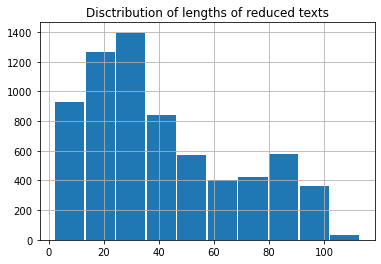

In [57]:
df_rus["length"] = df_rus.reduced_with_pos.apply(lambda x: len(x.split()))

print(f"Number of 0-length texts is {df_rus[df_rus.length.values == 0].shape[0]}")

df_rus["length"].hist(rwidth=0.95)
plt.title("Disctribution of lengths of reduced texts")
plt.show()

df_rus.drop(columns=["length"], inplace=True)

In [55]:
reduced_vocab = []

for text in lemmatized_reduced.values():
    for w in text:
        if w in reduced_vocab:
            continue
        else:
            reduced_vocab.append(w)
            
print(f"Length of the new vocabulary is {len(reduced_vocab)}, while the length of initial vocab was {len(vocab)}")

Length of the new vocabulary is 7468, while the length of initial vocab was 27549


Отже, нам вдалось зменшити словник в 4 рази, що є досить суттєвим результатом. Збережемо наші дані

In [58]:
df_rus.head(1)

,mention,clean_text,language,clipped_part_correct,translated_text,clean_rus,clean_rus_no_stopwords,index,lemmatized,lemmatized_with_pos,lemmatized_with_vectors_and_pos,reduced_with_pos,reduced_no_pos
0,Инверторные кондиционеры | Купить в Москве по ...,инверторные кондиционеры | купить в москве по ...,ru,NaN,инверторные кондиционеры | купить в москве по ...,инверторные кондиционеры купить в москве по вы...,инверторные кондиционеры купить москве выгодно...,0,инверторный кондиционер покупать москве выгодн...,инверторный_ADJ кондиционер_NOUN покупать_VERB...,кондиционер_NOUN покупать_VERB москве_NOUN выг...,кондиционер_NOUN купить_VERB москве_NOUN выгод...,кондиционер купить москве выгодный расценка ус...


In [59]:
writer = pd.ExcelWriter("home_appliances_rus_reduced.xlsx",
                        engine='xlsxwriter',
                        options={'strings_to_urls': False, 'strings_to_formulas': False})
df_rus.to_excel(writer)
writer.close()